In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib.patches as mpatches


In [2]:
sns.set_style("whitegrid")

COLORS = [
    "#E74C3C",  # 红
    "#64A8D6",  # 蓝
    "#A5E849",  # 绿
    "#F7C500",  # 金黄
    "#9D96D9",  # 紫
    "#6FE8D6",  # 青
    "#FF8C42"   # 橙
]

METHOD_ORDER = [
    # 'MUSTARD',
    'ScaleQuest-Math',
    'PromptCoT-QwQ',
    'PromptCoT-DS',
    'Conjecture-Prover',
    'Deductive Explorer (S)',
    'Deductive Explorer',
]

NAME_MAPPING = {
    'Deductive Explorer (S)' : 'DExplorer (Staged)',
    'Deductive Explorer' : 'DExplorer'
}

PALETTE_MAP = {
    'Deductive Explorer':      COLORS[0],  # 红
    'Deductive Explorer (S)':  COLORS[1],  # 蓝
    'Conjecture-Prover':       COLORS[2],  # 绿
    'PromptCoT-QwQ':           COLORS[3],  # 黄
    'PromptCoT-DS':            COLORS[4],  # 紫
    'ScaleQuest-Math':         COLORS[5],  # 青
    # 'MUSTARD':                 COLORS[6],  # 橙
}


In [13]:

def plot_line(data_line, out_file, x_label, y_label, title, ylim, new_figure=True):
    if new_figure:
        plt.figure(figsize=(24, 4))
    ax = plt.gca()

    for m in METHOD_ORDER:           # 按固定顺序
        if m in data_line:
            x_data, y_data = data_line[m]
            sns.lineplot(x=x_data, y=y_data, label=(NAME_MAPPING.get(m) or m), marker='o',
                         color=PALETTE_MAP[m], alpha=1.0, ax=ax)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    # ax.set_xlim(5.75, 8.5)

    # 设置x轴范围（log10处理后的值）
    ax.set_xlim(5.75, 8.5)

    # 计算主刻度：原数值为10^k的位置（k为整数）
    # 在5.75~8.5范围内，整数k为6、7、8
    major_ticks = [6, 6.5, 7, 7.5, 8, 8.5]
    ax.set_xticks(major_ticks)
    if x_label:
        ax.set_xticklabels([f'$10^{{{k}}}$' for k in major_ticks])  # 显示log值和原数值
    else:
        ax.set_xticklabels([])

        

    # 计算副刻度：每个数量级内的细分（原数值为10^k * 2~9）
    minor_ticks = []
    for k in [6, 7]:  # 只处理完整包含在范围内的数量级
        for m in range(2, 10):  # 2~9
            tick = k + np.log10(m)  # 转换为log10后的刻度位置
            if 5.75 < tick < 8.5:  # 确保在显示范围内
                minor_ticks.append(tick)
    for m in range(6, 10):  # 原数值6×10^5到9×10^5
        tick = 5 + np.log10(m)
        if 5.75 < tick < 6:
            minor_ticks.append(tick)
    for m in range(1, 4):  # 原数值1×10^8到3×10^8（因为10^0.5≈3.16）
        tick = 8 + np.log10(m)
        if 8 < tick < 8.5:
            minor_ticks.append(tick)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(axis='x', which='major')#, length=12, width=1.5, labelsize=10)
    ax.tick_params(axis='x', which='minor')#, length=6, width=1, labelsize=0)  # 不显示副刻度标签
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    
    ax.set_ylim(*ylim)
    ax.legend(loc="upper left", title='')
    plt.title(title)
    if new_figure:
        plt.tight_layout()
        plt.savefig(out_file)
        plt.close()


def _method_palette(data, colors, method_order=METHOD_ORDER):
    present = set(data['Method'].dropna().unique())
    if method_order is None:
        # 退路：按出现顺序（不排序）
        methods = [m for m in data['Method'] if pd.notna(m)]
        methods = list(dict.fromkeys(methods))
        cmap = {m: colors[i % len(colors)] for i, m in enumerate(methods)}
        return methods, cmap
    else:
        methods = [m for m in method_order if m in present]  # 按固定顺序取交集
        cmap = {m: PALETTE_MAP[m] for m in methods}          # 用固定映射
        return methods, cmap

def _kde_1d(y, y_grid, bw='scott'):
    """尽量用 scipy.stats.gaussian_kde；没有就退化为直方图+简单平滑。"""
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(y, bw_method=bw)
        dens = kde.evaluate(y_grid)
        dens = np.maximum(dens, 0)
        return dens
    except Exception:
        # fallback: 直方图 + 简单平滑
        hist, edges = np.histogram(y, bins=min(64, max(10, int(np.sqrt(len(y))))), range=(y_grid.min(), y_grid.max()), density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        dens = np.interp(y_grid, centers, hist, left=0, right=0)
        # 简单三点移动平均平滑两次
        for _ in range(2):
            dens = np.convolve(dens, [0.25, 0.5, 0.25], mode='same')
        dens = np.maximum(dens, 0)
        return dens

def plot_violin(
    data, out_file, x_col, y_col, x_label, y_label, title, ylim,
    base_width=0.35,   # 全局基准半宽
    dodge=0.22,        # 同一 x 内Method的水平间距
    bw_method='scott', # 统一 KDE 带宽
    y_grid_size=256,
    alpha=0.6,
    new_figure: bool=True,
    scaled_counts=None,
    line_y=None,
):
    if new_figure:
        plt.figure(figsize=(24, 4))
    ax = plt.gca()

    # —— 固定顺序与颜色（如你已定义 METHOD_ORDER/PALETTE_MAP 就用它们；否则退化为出现顺序）——
    # try:
    present = set(data['Method'].dropna().unique())
    methods = [m for m in METHOD_ORDER if m in present]  # 优先用固定顺序
    print(methods)
    palette_map = {m: PALETTE_MAP[m] for m in methods}
    # except Exception:
        # # 退路：按出现顺序并用 COLORS 轮转
        # methods = [m for m in data['Method'] if pd.notna(m)]
        # methods = list(dict.fromkeys(methods))
        # palette_map = {m: COLORS[i % len(COLORS)] for i, m in enumerate(methods)}

    # —— 统一 x 刻度（解决浮点抖动）——
    x_vals = np.array(sorted(np.unique(data[x_col].values)))
    x_round = None
    if np.issubdtype(x_vals.dtype, np.floating):
        x_round = np.round(x_vals, 3)
        x_vals = np.unique(x_round)

    # —— 统一 y 网格 —— 
    y_min, y_max = ylim
    y_grid = np.linspace(y_min, y_max, y_grid_size)

    # —— 统计 (x, Method) 原始计数 —— 
    from collections import defaultdict
    counts = defaultdict(int)
    for (xv, m), g in data.groupby([x_col, 'Method']):
        key = (round(xv, 3) if x_round is not None else xv, m)
        counts[key] = len(g)

    # —— 仅对 MUSTARD 做“等价 5000”缩放，其它Method不变 —— 
    if scaled_counts is None:
        scaled_counts = {}
        for (xv, m), n in counts.items():
            if m == 'MUSTARD':
                n_eff = n * (5000 / 28316)
            else:
                n_eff = n
            scaled_counts[(xv, m)] = n_eff
    else:
        pass

    # 全局最大按“有效计数”确定（确保跨 x 可比）
    global_max = max(scaled_counts.values()) if scaled_counts else 1.0

    # —— 生成并排偏移 —— 
    def offsets_for(n, step):
        if n == 1: return [0.0]
        idx = np.arange(n) - (n - 1) / 2.0
        return (idx * step).tolist()

    # —— 绘制 —— 
    for m_ in methods:
        for xv in x_vals:
            ms_here = [m for m in methods if scaled_counts.get((xv, m), 0) > 0]
            if not ms_here:
                continue
            offs = offsets_for(len(ms_here), dodge)
            print(ms_here)

            # 这一列的数据（按 x 对齐）
            sel_x = (np.round(data[x_col], 3) == xv) if x_round is not None else (data[x_col] == xv)
            df_x = data.loc[sel_x]

            for m, off in zip(ms_here, offs):
                if m != m_:
                    continue
                # print(m)
                y_series = df_x.loc[df_x['Method'] == m, y_col].values
                if len(y_series) < 2:
                    continue

                dens = _kde_1d(y_series, y_grid, bw=bw_method)
                area = np.trapz(dens, y_grid)
                if area <= 0:
                    continue
                dens_norm = dens / area  # 先把密度积分归一

                n_eff = scaled_counts[(xv, m)]
                # half_width = base_width * (n_eff / global_max)  # 半宽∝有效计数
                half_width = base_width

                x_right = (xv + off) + dens_norm * half_width
                x_left  = (xv + off) - dens_norm * half_width

                poly_x = np.concatenate([x_left[::-1], x_right])
                poly_y = np.concatenate([y_grid[::-1], y_grid])

                coll = PolyCollection([np.column_stack([poly_x, poly_y])],
                                    facecolor=palette_map[m], edgecolor='black',
                                    linewidth=0.6, alpha=alpha)
                ax.add_collection(coll)

    # for xv in x_vals:
    #     ms_here = [m for m in methods if scaled_counts.get((xv, m), 0) > 0]
    #     if not ms_here:
    #         continue
    #     offs = offsets_for(len(ms_here), dodge)
    #     print(ms_here)

    #     # 这一列的数据（按 x 对齐）
    #     sel_x = (np.round(data[x_col], 3) == xv) if x_round is not None else (data[x_col] == xv)
    #     df_x = data.loc[sel_x]

    #     for m, off in zip(ms_here, offs):
    #         # print(m)
    #         y_series = df_x.loc[df_x['Method'] == m, y_col].values
    #         if len(y_series) < 2:
    #             continue

    #         dens = _kde_1d(y_series, y_grid, bw=bw_method)
    #         area = np.trapz(dens, y_grid)
    #         if area <= 0:
    #             continue
    #         dens_norm = dens / area  # 先把密度积分归一

    #         n_eff = scaled_counts[(xv, m)]
    #         half_width = base_width * (n_eff / global_max)  # 半宽∝有效计数

    #         x_right = (xv + off) + dens_norm * half_width
    #         x_left  = (xv + off) - dens_norm * half_width

    #         poly_x = np.concatenate([x_left[::-1], x_right])
    #         poly_y = np.concatenate([y_grid[::-1], y_grid])

    #         coll = PolyCollection([np.column_stack([poly_x, poly_y])],
    #                               facecolor=palette_map[m], edgecolor='black',
    #                               linewidth=0.6, alpha=alpha)
    #         ax.add_collection(coll)

    # —— 轴 & 图例 —— 
    # ax.set_xlim(x_vals.min()-0.25, x_vals.max()+0.25)
    # 设置x轴范围（log10处理后的值）
    if line_y:
        ax.axhline(y=line_y, color='black', linestyle=':', alpha=0.5)

    
    ax.set_xlim(5.75, 8.5)

    # 计算主刻度：原数值为10^k的位置（k为整数）
    # 在5.75~8.5范围内，整数k为6、7、8
    major_ticks = [6, 6.5, 7, 7.5, 8, 8.5]
    ax.set_xticks(major_ticks)
    if x_label:
        ax.set_xticklabels([f'$10^{{{k}}}$' for k in major_ticks])  # 显示log值和原数值
    else:
        ax.set_xticklabels([])

    # 计算副刻度：每个数量级内的细分（原数值为10^k * 2~9）
    minor_ticks = []
    for k in [6, 7]:  # 只处理完整包含在范围内的数量级
        for m in range(2, 10):  # 2~9
            tick = k + np.log10(m)  # 转换为log10后的刻度位置
            if 5.75 < tick < 8.5:  # 确保在显示范围内
                minor_ticks.append(tick)
    for m in range(6, 10):  # 原数值6×10^5到9×10^5
        tick = 5 + np.log10(m)
        if 5.75 < tick < 6:
            minor_ticks.append(tick)
    for m in range(1, 4):  # 原数值1×10^8到3×10^8（因为10^0.5≈3.16）
        tick = 8 + np.log10(m)
        if 8 < tick < 8.5:
            minor_ticks.append(tick)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(axis='x', which='major')#, length=12, width=1.5, labelsize=10)
    ax.tick_params(axis='x', which='minor')#, length=6, width=1, labelsize=0)  # 不显示副刻度标签
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    present = set(data['Method'].dropna().unique())
    handles = [
        mpatches.Patch(color=PALETTE_MAP[m], label=m)
        for m in PALETTE_MAP.keys() if m in present
    ]
    # ax.legend(handles=handles, loc='upper left', title='')

    if new_figure:
        plt.tight_layout()
        plt.savefig(out_file)
        plt.close()
    return scaled_counts






def debug_counts(data, x_col="Total Cost", hue_col="Method", focus_x=None, round_x=3):
    """
    打印每个(Total Cost, Method)的样本数。
    - focus_x: 只查看某个x位置（例如 8.0）；为None则显示所有x的摘要。
    - round_x: 为了避免浮点精度，把x先四舍五入到指定位数再分组。
    """
    df = data.copy()
    # 处理浮点误差：把x刻度先round一下
    if pd.api.types.is_float_dtype(df[x_col]):
        df[x_col] = df[x_col].round(round_x)

    # 统计 (x, Method) 计数
    tbl = (df.groupby([x_col, hue_col]).size()
             .rename("n").reset_index())

    if focus_x is not None:
        # 只看某个x
        sub = tbl[tbl[x_col] == focus_x].sort_values("n", ascending=False)
        print(f"\n=== Counts at {x_col} = {focus_x} ===")
        print(sub.to_string(index=False))
        # 同时给出这一列的总量对比（按Method）
        print("\nSum by Method at this x:")
        print(sub.groupby(hue_col)["n"].sum().sort_values(ascending=False).to_string())
        return sub

    # 不指定x时，给出两个汇总视角
    print("\n=== Counts by (x, Method) head ===")
    print(tbl.sort_values([x_col, "n"], ascending=[True, False]).head(20).to_string(index=False))

    print("\n=== Total by Method (overall) ===")
    print(tbl.groupby(hue_col)["n"].sum().sort_values(ascending=False).to_string())

    print("\n=== Unique x values (rounded) ===")
    print(sorted(df[x_col].unique()))
    return tbl


def last_x_value(data, x_col="Total Cost", round_x=3):
    """找出数据里最大的x刻度（已round），用于‘看最后一个x刻度’的计数。"""
    xvals = pd.Series(data[x_col])
    if pd.api.types.is_float_dtype(xvals):
        xvals = xvals.round(round_x)
    return xvals.max()



In [14]:
# stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# # ----------- 图1：valid statements 折线 -----------
# with open('cost_valid_complexity.data.pkl', 'rb') as f:
#     data_valid, data_line_valid = pickle.load(f)

# plot_line(
#     data_line=data_line_valid,
#     out_file=f'valid_statements_line_1_{stamp}.pdf',
#     x_label=r'Token Cost $(\log_{10})$',
#     y_label='Success Rate (%)',
#     ylim=(0, 60)
# )

# # ----------- 图2：valid statements 小提琴 -----------
# # plot_violin(
# #     data=data_valid,
# #     out_file=fvalid_statements_violin_2_{stamp}.pdf',
# #     x_col="Total Cost",
# #     y_col="Complexity",
# #     y_label='Complexity',
# #     ylim=(0, 1500),
# #     width_main=10
# # )
# scaled_counts=plot_violin(
#     data=data_valid,
#     out_file=f'valid_statements_violin_2_{stamp}.pdf',
#     x_col="Total Cost",
#     y_col="Complexity",
#     x_label=r'Token Cost $(\log_{10})$',
#     y_label='Complexity',
#     ylim=(0, 1500),
#     base_width=18.65,   # 可微调：越大越宽
#     dodge=0.22,        # 同一 x 内各Method的水平间距
#     bw_method='scott', # 带宽统一；也可以 'silverman' 或 0.2, 0.3 这类数值
#     y_grid_size=256,
#     alpha=0.6
# )


# # ----------- 图3：problem-solving 小提琴 -----------
# with open('cost_valid-solving_difficulty.data.pkl', 'rb') as f:
#     data_ps, data_line_ps = pickle.load(f)

# # plot_violin(
# #     data=data_ps,
# #     out_file=fproblem_solving_violin_3_{stamp}.pdf',
# #     x_col="Total Cost",
# #     y_col="Complexity",
# #     y_label='Item Difficulty',
# #     ylim=(0, 1),
# #     width_main=10
# # )
# plot_violin(
#     data=data_ps,
#     out_file=f'problem_solving_violin_3_{stamp}.pdf',
#     x_col="Total Cost",
#     y_col="Complexity",
#     x_label=r'Token Cost $(\log_{10})$',
#     y_label='Item Difficulty',
#     ylim=(0, 1),
#     base_width=0.02,
#     dodge=0.22,
#     bw_method='scott',
#     y_grid_size=256,
#     alpha=0.6,
#     scaled_counts=scaled_counts
# )




# debug_counts(data_valid, x_col="Total Cost", hue_col="Method")

# # 只看‘最后一个x刻度’的计数（你关心的那个位置）
# x_last = last_x_value(data_valid, x_col="Total Cost")
# debug_counts(data_valid, x_col="Total Cost", hue_col="Method", focus_x=x_last)

# debug_counts(data_ps, x_col="Total Cost", hue_col="Method")
# x_last_ps = last_x_value(data_ps, x_col="Total Cost")
# debug_counts(data_ps, x_col="Total Cost", hue_col="Method", focus_x=x_last_ps)

# def count_at(data, xs, x_col="Total Cost", hue_col="Method", round_x=3):
#     df = data.copy()
#     if df[x_col].dtype.kind in "fc":
#         df[x_col] = df[x_col].round(round_x)
#     xs = [round(float(x), round_x) for x in xs]
#     sub = (df[df[x_col].isin(xs)]
#            .groupby([x_col, hue_col]).size()
#            .rename("n").reset_index()
#            .sort_values([x_col, "n"], ascending=[True, False]))
#     print(sub.to_string(index=False))
#     return sub

# # 例如你图里框出的那几个位置（按需改）：
# count_at(data_valid, [7.358, 7.361, 8.032, 8.086])

['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']


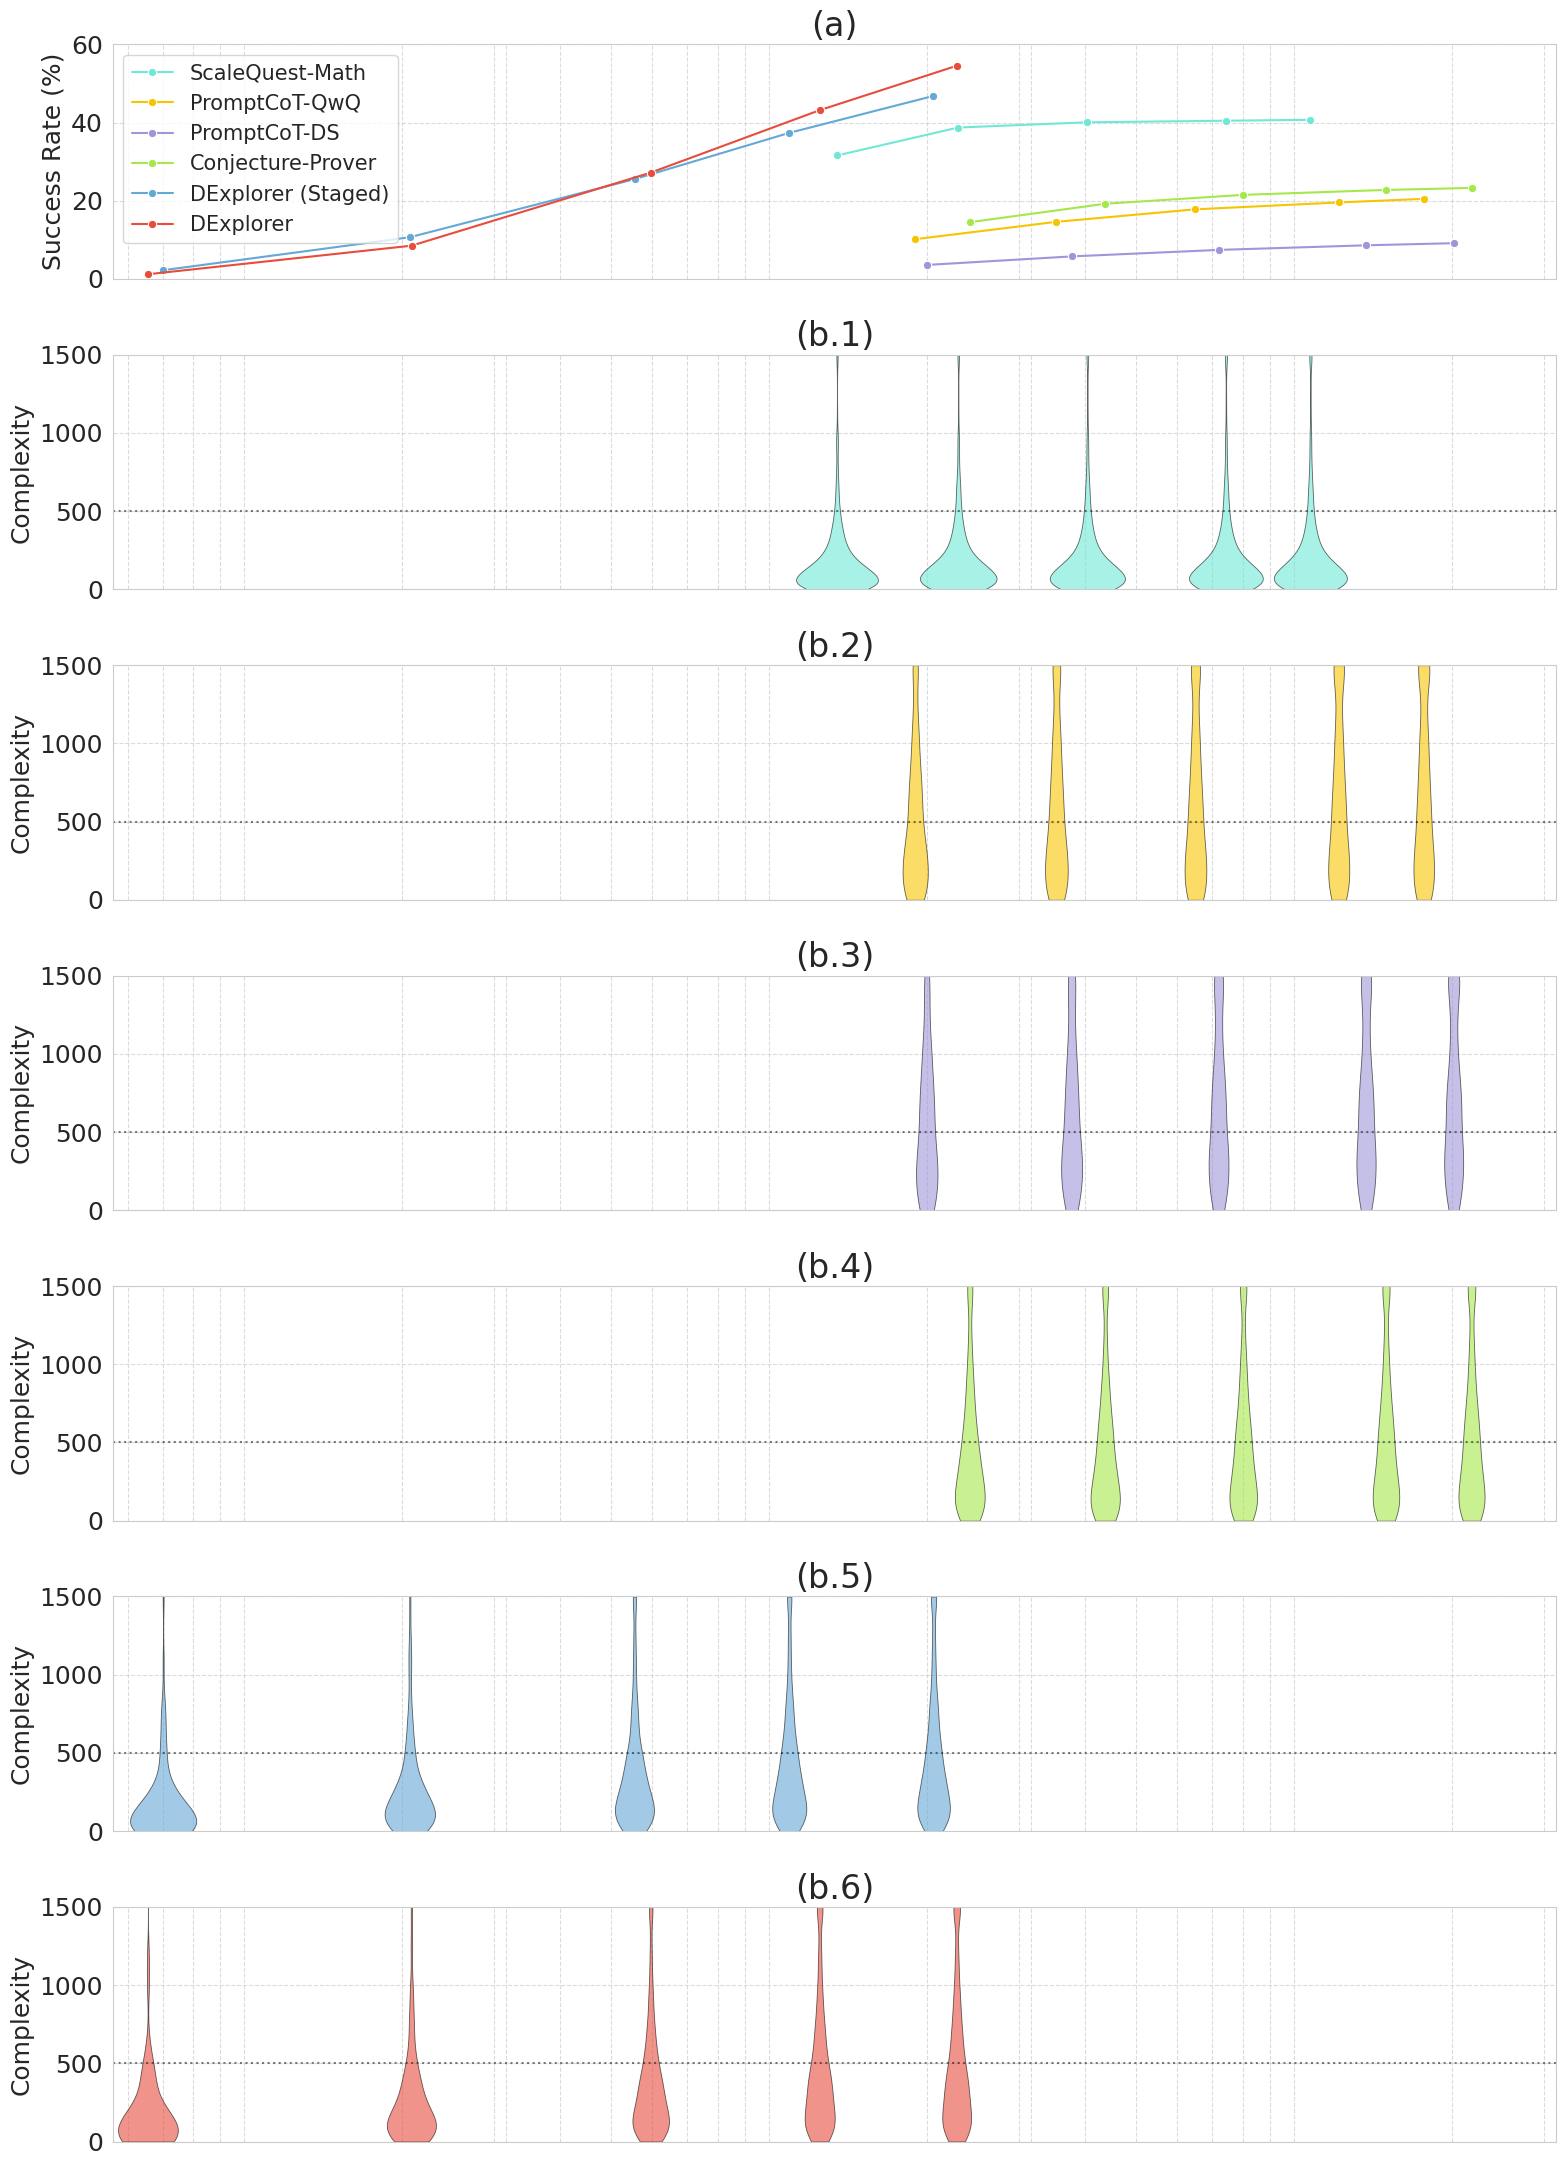

In [33]:
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

fontsize_coeff = 1.5
plt.rcParams.update({
    'font.size': 12*fontsize_coeff,         # 全局字体大小
    'axes.titlesize': 16*fontsize_coeff,    # 标题字体大小
    'axes.labelsize': 12*fontsize_coeff,    # 轴标签字体大小
    'xtick.labelsize': 12*fontsize_coeff,   # x轴刻度字体大小
    'ytick.labelsize': 12*fontsize_coeff,   # y轴刻度字体大小
    'legend.fontsize': 10*fontsize_coeff    # 图例字体大小
})

# ----------- 图1：valid statements 折线 -----------
with open('cost_valid_complexity.data.pkl', 'rb') as f:
    data_valid, data_line_valid = pickle.load(f)

plt.figure(figsize=(16, 3*(len(METHOD_ORDER)+1)+1))
plt.subplot(1+len(METHOD_ORDER), 1, 1)

plot_line(
    data_line=data_line_valid,
    out_file=f'valid_statements_line_1_{stamp}.pdf',
    # x_label=r'Token Cost $(\log_{10})$',
    x_label=r'',
    y_label='Success Rate (%)',
    title='(a)',
    ylim=(0, 60),
    new_figure=False
)

for i, m in enumerate(METHOD_ORDER):
    plt.subplot(1+len(METHOD_ORDER), 1, 2+i)
        
    scaled_counts=plot_violin(
        data=data_valid[data_valid['Method'] == m],
        out_file=f'valid_statements_violin_2_{stamp}.pdf',
        x_col="Total Cost",
        y_col="Complexity",
        x_label=r'',
        y_label='Complexity',
        title=f'(b.{i+1})',
        ylim=(0, 1500),
        base_width=18.65,   # 可微调：越大越宽
        dodge=0.22,        # 同一 x 内各Method的水平间距
        bw_method='scott', # 带宽统一；也可以 'silverman' 或 0.2, 0.3 这类数值
        y_grid_size=256,
        alpha=0.6,
        new_figure=False,
        line_y=500,
    )

# plt.subplot(3, 1, 3)
# # ----------- 图3：problem-solving 小提琴 -----------
# with open('cost_valid-solving_difficulty.data.pkl', 'rb') as f:
#     data_ps, data_line_ps = pickle.load(f)

# plot_violin(
#     data=data_ps,
#     out_file=f'problem_solving_violin_3_{stamp}.pdf',
#     x_col="Total Cost",
#     y_col="Complexity",
#     x_label=r'Total Token Cost',
#     y_label='Item Difficulty (← Difficult)',
#     title='(c)',
#     ylim=(0, 1),
#     base_width=0.02,
#     dodge=0.22,
#     bw_method='scott',
#     y_grid_size=256,
#     alpha=0.6,
#     new_figure=False,
#     scaled_counts=scaled_counts,
#     line_y=0.75,
# )

plt.tight_layout()
plt.savefig('fig3-complexity.pdf')


['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['ScaleQuest-Math']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-QwQ']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['PromptCoT-DS']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Conjecture-Prover']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer (S)']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']
['Deductive Explorer']


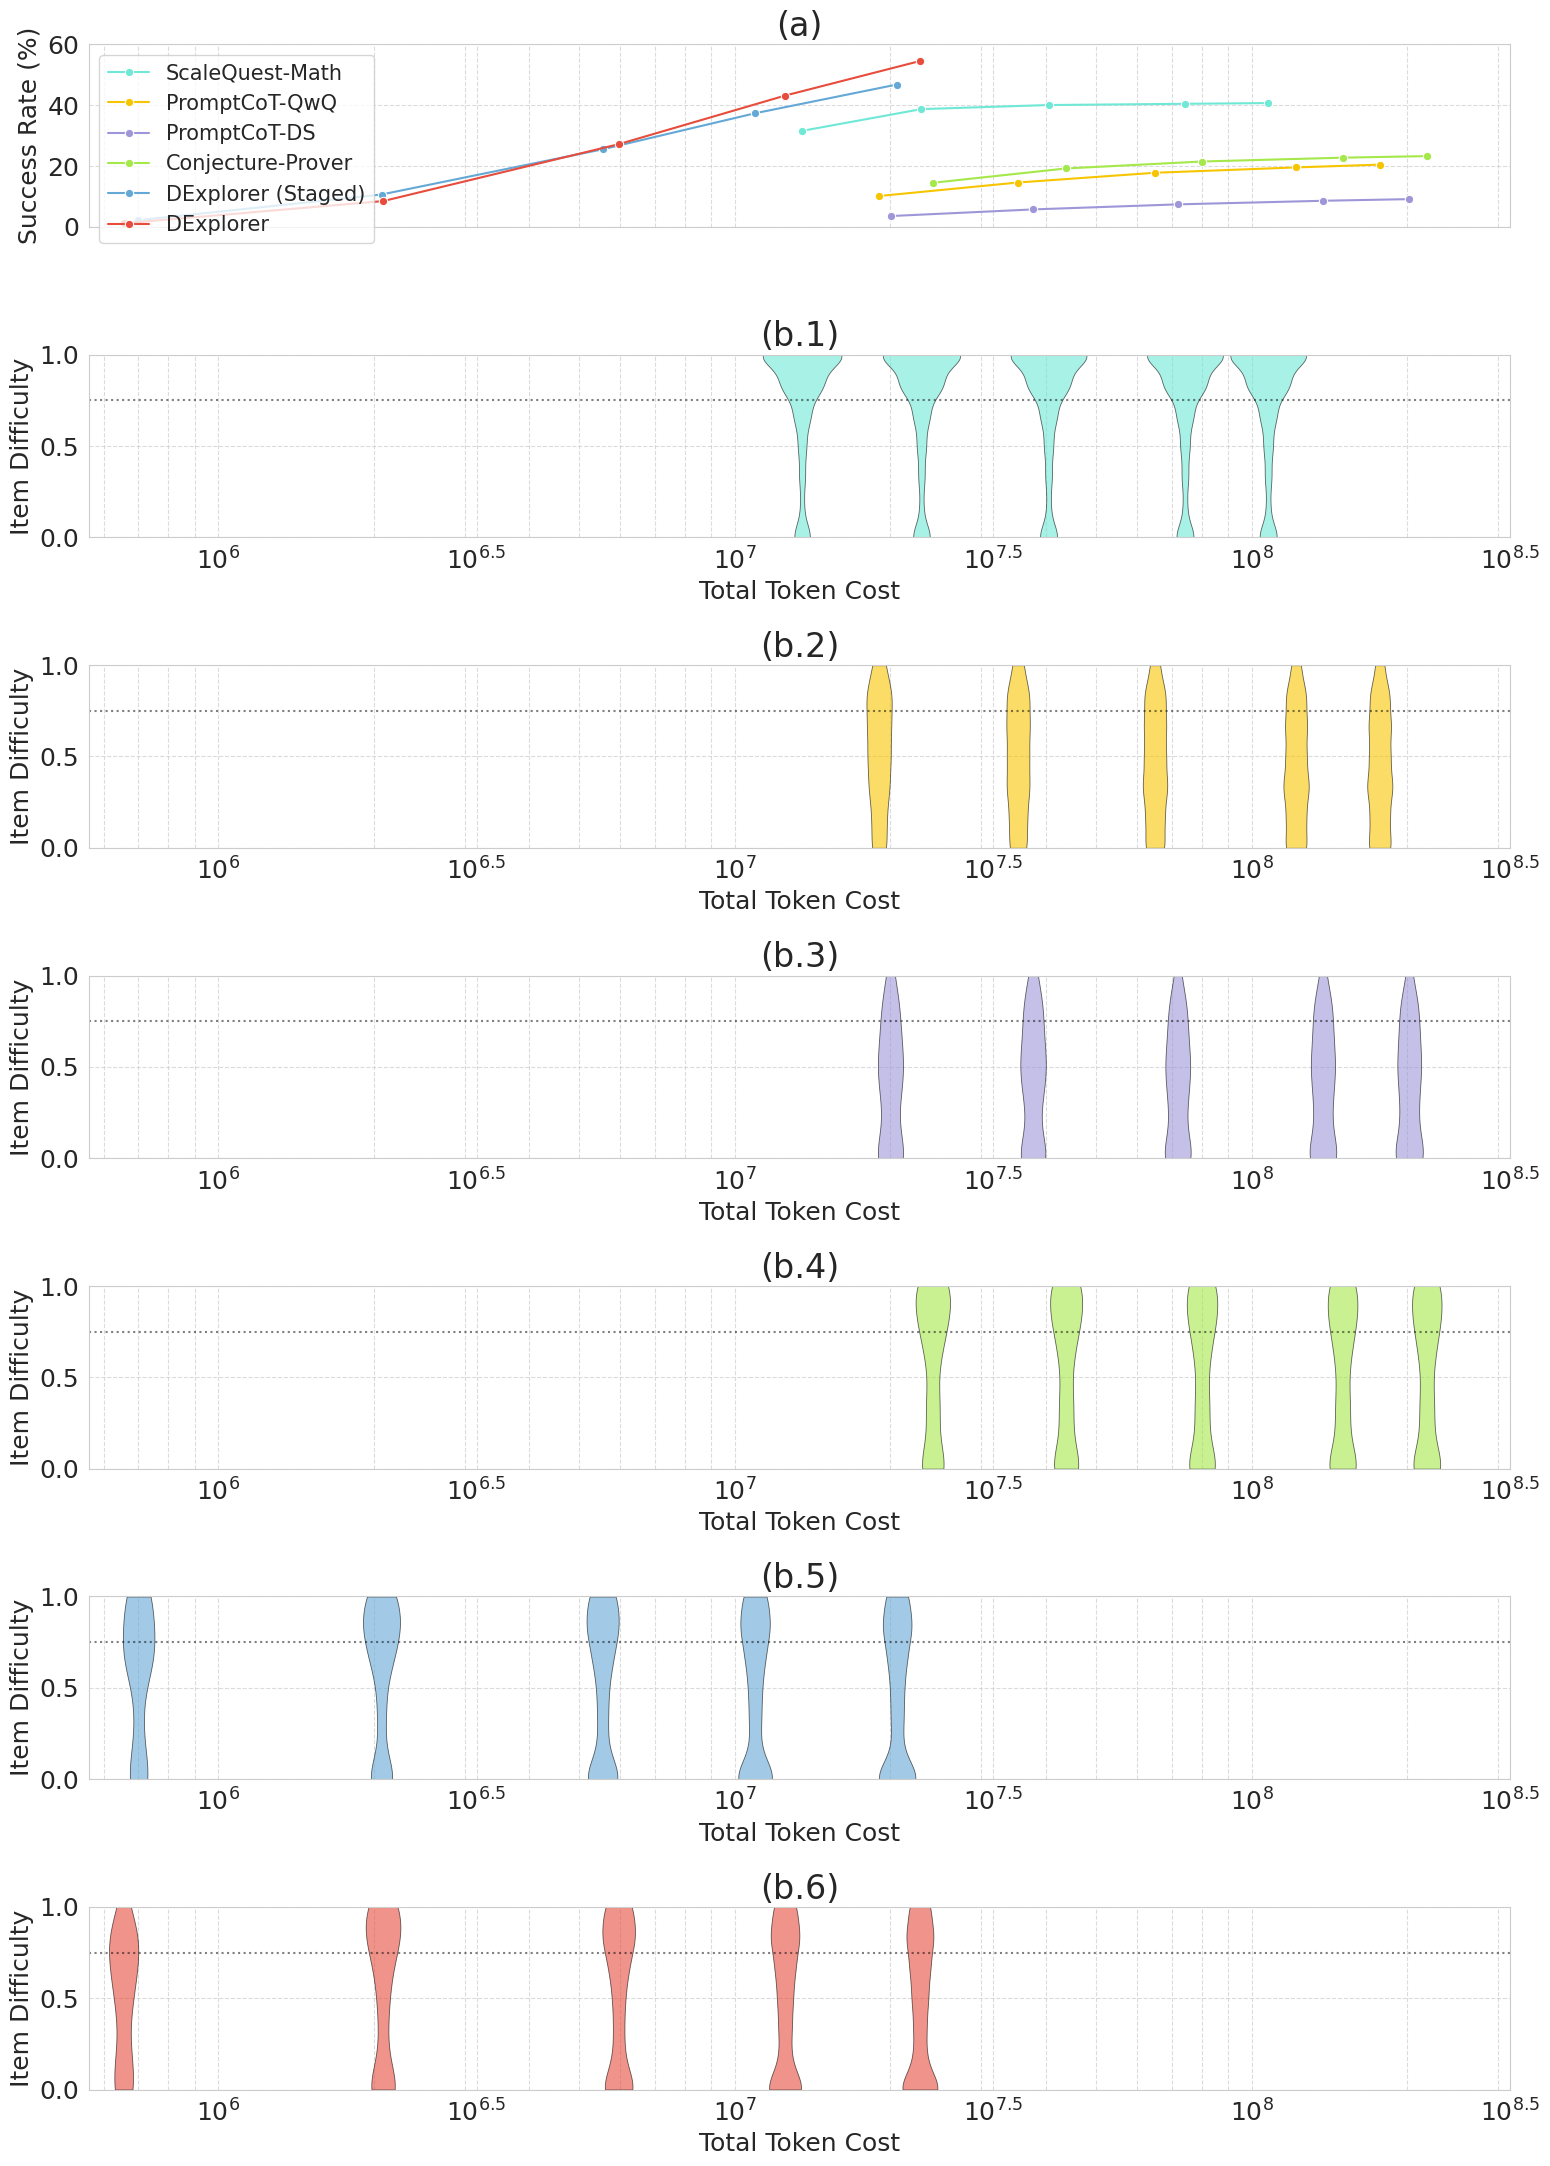

In [34]:
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

fontsize_coeff = 1.5
plt.rcParams.update({
    'font.size': 12*fontsize_coeff,         # 全局字体大小
    'axes.titlesize': 16*fontsize_coeff,    # 标题字体大小
    'axes.labelsize': 12*fontsize_coeff,    # 轴标签字体大小
    'xtick.labelsize': 12*fontsize_coeff,   # x轴刻度字体大小
    'ytick.labelsize': 12*fontsize_coeff,   # y轴刻度字体大小
    'legend.fontsize': 10*fontsize_coeff    # 图例字体大小
})

# ----------- 图1：valid statements 折线 -----------
with open('cost_valid_complexity.data.pkl', 'rb') as f:
    data_valid, data_line_valid = pickle.load(f)

plt.figure(figsize=(16, 3*(len(METHOD_ORDER)+1)+1))
plt.subplot(1+len(METHOD_ORDER), 1, 1)

plot_line(
    data_line=data_line_valid,
    out_file=f'valid_statements_line_1_{stamp}.pdf',
    # x_label=r'Token Cost $(\log_{10})$',
    x_label=r'',
    y_label='Success Rate (%)',
    title='(a)',
    ylim=(0, 60),
    new_figure=False
)

with open('cost_valid-solving_difficulty.data.pkl', 'rb') as f:
    data_ps, data_line_ps = pickle.load(f)

for i, m in enumerate(METHOD_ORDER):
    plt.subplot(1+len(METHOD_ORDER), 1, 2+i)
        
    plot_violin(
        data=data_ps[data_ps['Method'] == m],
        out_file=f'problem_solving_violin_3_{stamp}.pdf',
        x_col="Total Cost",
        y_col="Complexity",
        x_label=r'Total Token Cost',
        y_label='Item Difficulty',
        title=f'(b.{i+1})',
        ylim=(0, 1),
        base_width=0.02,
        dodge=0.22,
        bw_method='scott',
        y_grid_size=256,
        alpha=0.6,
        new_figure=False,
        line_y=0.75,
    )

plt.tight_layout()
plt.savefig('fig3-difficulty.pdf')


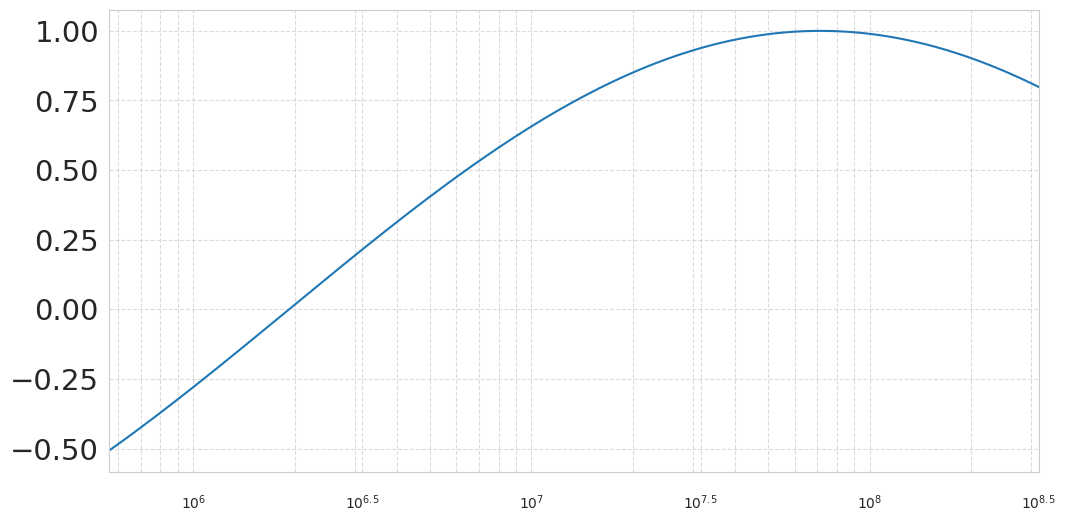

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 创建示例数据（x为log10处理后的值，范围5.75~8.5）
x = np.linspace(5.75, 8.5, 200)
y = np.sin(x)  # 示例y值

# 绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, y)

# 设置x轴范围（log10处理后的值）
ax.set_xlim(5.75, 8.5)

# 计算主刻度：原数值为10^k的位置（k为整数）
# 在5.75~8.5范围内，整数k为6、7、8
major_ticks = [6, 6.5, 7, 7.5, 8, 8.5]
ax.set_xticks(major_ticks)
ax.set_xticklabels([f'$10^{{{k}}}$' for k in major_ticks])  # 显示log值和原数值

# 计算副刻度：每个数量级内的细分（原数值为10^k * 2~9）
minor_ticks = []
for k in [6, 7]:  # 只处理完整包含在范围内的数量级
    for m in range(2, 10):  # 2~9
        tick = k + np.log10(m)  # 转换为log10后的刻度位置
        if 5.75 < tick < 8.5:  # 确保在显示范围内
            minor_ticks.append(tick)
for m in range(6, 10):  # 原数值6×10^5到9×10^5
    tick = 5 + np.log10(m)
    if 5.75 < tick < 6:
        minor_ticks.append(tick)
for m in range(1, 4):  # 原数值1×10^8到3×10^8（因为10^0.5≈3.16）
    tick = 8 + np.log10(m)
    if 8 < tick < 8.5:
        minor_ticks.append(tick)
ax.set_xticks(minor_ticks, minor=True)
ax.tick_params(axis='x', which='major', length=12, width=1.5, labelsize=10)
ax.tick_params(axis='x', which='minor', length=6, width=1, labelsize=0)  # 不显示副刻度标签
ax.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()
    

In [7]:
minor_ticks

[6.301029995663981,
 6.477121254719663,
 6.6020599913279625,
 6.698970004336019,
 6.778151250383644,
 6.845098040014257,
 6.903089986991944,
 6.954242509439325,
 7.301029995663981,
 7.477121254719663,
 7.6020599913279625,
 7.698970004336019,
 7.778151250383644,
 7.845098040014257,
 7.903089986991944,
 7.954242509439325,
 5.778151250383644,
 5.845098040014257,
 5.903089986991944,
 5.954242509439325,
 8.301029995663981,
 8.477121254719663]